### Import all necessary libraries

In [25]:
#!pip install seaborn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import sklearn
import nltk.collocations 
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import string, re
import urllib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
#nltk.download('punkt')
#nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Read CSV Data

In [26]:
song_list = pd.read_csv('380lyrics.csv')
charts = pd.read_csv('chart.csv')

### Remove Rows with Other and Not Available Genre

In [27]:
song_list.year.value_counts()

2006    76590
2007    63677
2016    37409
2015    28766
2014    28250
2008    21497
2013    17331
2012    15789
2010    12106
2011    12067
2009    12029
2005     5719
2004     3698
2003     2187
2002     2158
2000     1722
1999     1586
2001     1570
1990     1362
1997     1304
1998     1285
1996     1236
1995     1160
1994      968
1993      918
1992      907
1991      559
1977      552
1971      541
1973      520
1989      511
1972      509
1982      498
1970      429
1979      420
1981      414
1974      410
1978      407
1980      401
1988      388
1986      365
1975      364
1983      359
1976      344
1985      333
1987      307
1984      298
2038       10
112         4
702         1
1968        1
67          1
Name: year, dtype: int64

In [28]:
song_list.drop(song_list[song_list.genre == "Other"].index, inplace = True)
song_list.drop(song_list[song_list.genre == "Not Available"].index, inplace = True)
song_list.drop(song_list[song_list.genre == "Indie"].index, inplace = True)
song_list.drop(song_list[song_list.genre == "Folk"].index, inplace = True)
song_list.drop(song_list[song_list.artist == "dolcenera"].index, inplace = True)
song_list.drop(song_list[song_list.artist == "brthhse-onkelz"].index, inplace = True)
song_list.shape

(299523, 6)

In [29]:
song_list.tail()

,index,song,year,artist,genre,lyrics
362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...
362236,362236,amen,2012,edens-edge,Country,I heard from a friend of a friend of a friend ...


### Drop rows with NAN values for column song

In [30]:
song_list.dropna(inplace = True)
song_list.song.isna().sum()
song_list.reset_index(inplace = True)

In [31]:
song_list.tail()

,level_0,index,song,year,artist,genre,lyrics
231786,362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
231787,362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
231788,362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
231789,362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...
231790,362236,362236,amen,2012,edens-edge,Country,I heard from a friend of a friend of a friend ...


### Clean Song titles to remove dashes and capitalize

In [32]:
def clean_song_names(titles_list):
    no_dot = list(map(lambda item: item.replace(".", ""), titles_list))
    no_dash = list(map(lambda item: item.replace("-", " "), no_dot))
    no_app = list(map(lambda item: item.replace("'", " "), no_dash))
    return list(map(lambda item: string.capwords(item), no_app))

titles_list = song_list.song
final_titles = clean_song_names(titles_list)
len(final_titles)
# final_titles

231791

### Append Clean Song names to DF as a new column and drop old column

In [33]:
new_df = song_list
# new_df.head()
new_titles = final_titles


new_lyr = pd.DataFrame(new_titles)
new_lyr.tail()

final_df = new_df.join(new_lyr)

final_df.drop(columns = ['song', 'level_0', "index"], axis = 1, inplace = True)


In [34]:
final_df.rename(columns = {0: "song"}, inplace = True)
final_df.isna().sum()

year      0
artist    0
genre     0
lyrics    0
song      0
dtype: int64

In [35]:
final_df.shape

(231791, 5)

### Clean top of charts songs, append songs back to original charts pandas DataFrame, drop original song column

In [36]:
# Clean chart songs
clean_chart_songs = clean_song_names(charts.song)

# create panda dataframe on clean_chart_songs
df_cleaned_chart_songs = pd.DataFrame(np.array(clean_chart_songs))
df_cleaned_chart_songs.head()

,0
0,Infinity 2008
1,Pick Up The Phone
2,Rain Over Me
3,All I Want For Christmas Is You
4,It S Time


In [37]:
count = 0
for item in clean_chart_songs:
    if item in final_titles:
        count += 1
count

1808

In [38]:
# append df_cleaned_chart_songs to charts
final_charts = charts.join(df_cleaned_chart_songs)
final_charts.drop(columns=['song'], axis=1, inplace=True)
final_charts.rename(columns = {0: "song"}, inplace=True)
final_charts.set_index('song',inplace=True)
final_charts.head()

,Top_chart
song,
Infinity 2008,1
Pick Up The Phone,1
Rain Over Me,1
All I Want For Christmas Is You,1
It S Time,1


In [39]:
final_df.set_index('song', inplace=True)
final_df.head()

,year,artist,genre,lyrics
song,,,,
Ego Remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
Then Tell Me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
Honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
You Are My Rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
Black Culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [40]:
new_df = final_df.join(final_charts,how='left')
new_df.Top_chart.fillna(0, inplace = True)
new_df.head()

,year,artist,genre,lyrics,Top_chart
song,,,,,
0 0,2006,fear-factory,Metal,Long live the new flesh!\nWhere evil dwells\nN...,0.0
0 0 0,2007,earthtone9,Metal,thousand rays\nthousand leaves\nthousand breat...,0.0
0 0 Where Evil Dwells,2008,fear-factory,Metal,Long live the new flesh\nWhere evil dwells\nNo...,0.0
0 To 100,2014,drake,Hip-Hop,Fuck bein' on some chill shit\nWe go 0 to 100 ...,0.0
0 To 100 Freestyle,2014,ace-hood,Hip-Hop,"Better watch your Mrs., I'mma shoplift\nGo to ...",0.0


In [43]:
new_df.Top_chart.value_counts()

0.0    220415
1.0     11468
Name: Top_chart, dtype: int64

In [44]:
final_df = new_df

### Drop Song titles with Nan Values

In [45]:
final_df.genre.value_counts()

Rock          109030
Pop            40490
Hip-Hop        24862
Metal          23763
Country        14387
Jazz            7978
Electronic      7972
R&B             3401
Name: genre, dtype: int64

In [46]:
rock_df = final_df[final_df.genre == "Rock"][-900:]
pop_df = final_df[final_df.genre == "Pop"][30000:35000]
hip_df = final_df[final_df.genre == "Hip-Hop"][:900]
metal_df = final_df[final_df.genre == "Metal"][:900]
jazz_df = final_df[final_df.genre == "Jazz"][:4000]
elec_df = final_df[final_df.genre == "Electronic"][:900]
country_df = final_df[final_df.genre == "Country"][:900]
rnb_df = final_df[final_df.genre == "R&B"][:900]


In [47]:
final_df.drop(final_df[final_df.genre == "Rock"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Pop"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Hip-Hop"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Metal"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Jazz"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Electronic"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Country"].index, inplace = True)


In [48]:
maybe_df = final_df.append([rock_df, pop_df, hip_df, metal_df, jazz_df, elec_df, country_df])
maybe_df.genre.value_counts()

Pop           5000
Jazz          4000
R&B           1842
Hip-Hop        900
Electronic     900
Metal          900
Country        900
Rock           900
Name: genre, dtype: int64

In [49]:
maybe_df.drop(maybe_df[maybe_df.genre == "R&B"].index, inplace = True)
maybe_df = maybe_df.append([rnb_df])

In [50]:
maybe_df.genre.value_counts()

Pop           5000
Jazz          4000
Hip-Hop        900
Electronic     900
Metal          900
Country        900
R&B            900
Rock           900
Name: genre, dtype: int64

### WC df creation

In [51]:
wc_df = maybe_df

In [53]:
maybe_df.Top_chart.value_counts()

0.0    13695
1.0      705
Name: Top_chart, dtype: int64

In [54]:
maybe_df.reset_index(inplace = True)

In [55]:
maybe_df.head()

,song,year,artist,genre,lyrics,Top_chart
0,You Re Only Young Once,2007,amber-pacific,Rock,Cheers to the day I'm on my way\nI'm living in...,0.0
1,You Re Our Two,2007,deerhoof,Rock,Hidden gamble.\nDouble meeting. We are the rem...,0.0
2,You Re Pretty Good,2007,chixdiggit,Rock,We get done with the show and\nwe're sweating ...,0.0
3,You Re Pretty When I Am Drunk,2006,bloodhound-gang,Rock,One night me and the crew hit the road on a mi...,0.0
4,You Re Pretty When I M Drunk,2006,bloodhound-gang,Rock,One night me and the crew hit the road on a mi...,0.0


In [56]:
lyrics_list = list(maybe_df.lyrics)

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
english = list(set(nltk.corpus.words.words()))

def clean_docs_lemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

def clean_docs_stemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_stemmas = [stemmer.stem(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_stemmas)
        cleaned.append(c)
    return cleaned

### First thing we wanted to do is test whether Lemmatizing works better than Stemmatizing

### Stemmed Lyrics Test

In [ ]:
stemmed_lyrics = clean_docs_stemma(lyrics_list)


In [ ]:
stemmed_lyrics[-1:]

In [ ]:
X = stemmed_lyrics
y = maybe_df.Top_chart

len(X) == len(y)

In [ ]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18) 

In [ ]:
# adaboost_clf = AdaBoostClassifier(learning_rate=0.3)
# gbt_clf = GradientBoostingClassifier(learning_rate=0.3)

pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

pipe_ADA = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', AdaBoostClassifier(learning_rate=0.3))
                    ])

pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])

pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())
                    ])

# List of pipelines, List of pipeline names
pipelines = [pipe_NB, pipe_RF, pipe_ADA, pipe_GBoost, pipe_KNN]
pipeline_names = ['Multinomail NB', 'Random Forest', 'ADA', "Gboost", "KNN"]

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)

# Compare accuracies
basic_scores = []
for index, val in enumerate(pipelines):
    tup = (pipeline_names[index], val.score(X_test, y_test))
    basic_scores.append(tup)
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

In [ ]:
modles_stem = [item[0] for item in basic_scores]
accuracy_stem = [item[1] for item in basic_scores]

plt.figure(figsize=(10,6))
plt.title("Basic Model Scores for Stemmed Data")
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.bar(modles_stem, accuracy_stem)

### Lemmed Lyrics Test

In [ ]:
lemmed_lyrics = clean_docs_lemma(lyrics_list)

In [ ]:
lemmed_lyrics[-1:]

In [ ]:
X = lemmed_lyrics
y = maybe_df.Top_chart

len(X) == len(y)

In [ ]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18) 

In [ ]:
pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha = 0.25))
                    ])

pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

pipe_ADA = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', AdaBoostClassifier(learning_rate=0.3))
                    ])

pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])

pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())
                    ])

# List of pipelines, List of pipeline names
pipelines = [pipe_NB, pipe_RF, pipe_ADA, pipe_GBoost, pipe_KNN]
pipeline_names = ['Multinomail NB', 'Random Forest', 'ADA', "Gboost", "KNN"]

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)

# Compare accuracies
lemmed_basic_scores = []
for index, val in enumerate(pipelines):
    tup = (pipeline_names[index], val.score(X_test, y_test))
    lemmed_basic_scores.append(tup)
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

In [ ]:
lemmed_basic_scores

In [ ]:
basic_scores

In [ ]:
modles_lem = [item[0] for item in lemmed_basic_scores]
accuracy_lem = [item[1] for item in lemmed_basic_scores]


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 5

means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)


fig, ax = plt.subplots(figsize = (12, 8))


index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.5
error_config = {'ecolor': '0.3'}

lemmed_bars = ax.bar(index, accuracy_lem, bar_width,
                alpha=opacity, color='b',
                label='Lematized')

stemmed_bars = ax.bar(index + bar_width, accuracy_stem, bar_width,
                alpha=opacity, color='r',
                label='Stemmatized')

ax.set_xlabel('Model Type', fontsize = 14)
ax.set_ylabel('Accuracy Scores', fontsize = 14)
ax.set_title('Stemmed vs. Lemmed Accuracy Score Comparison', fontsize = 18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(modles_lem)

plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
ax.legend()


plt.show()


### We decided to pick Lemmatized over Stemmatized and top three models for further optimization

### Next we want to try using PCA to improve performance and reduce dimentionality

In [ ]:
# tfidf = TfidfVectorizer()
# response = tfidf.fit_transform(lemmed_lyrics)

# PCA_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())
# PCA_df.shape

In [ ]:
# DATA = response  # this comes from above where you're vectorizing tdif dictionary

# non_zero_cols = DATA.nnz / float(DATA.shape[0])
# print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

# percent_sparse = 1 - (non_zero_cols / float(DATA.shape[1]))
# print('Percentage of columns containing 0: {}'.format(percent_sparse))

In [ ]:
# PCA_df.head()

### Creating Features table and Target table and testing first model

In [ ]:
# X_pca = PCA_df
# y_pca = maybe_df.Top_chart

# # len(y_pca)
# X_pca.shape

In [ ]:
# from sklearn.model_selection import train_test_split  
# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3, random_state=18)

### Try different PCA values and pick a number that preserves sufficient % of variation

In [ ]:
# from sklearn.decomposition import PCA
# # pca_1 = PCA(n_components=1455)
# # pca_2 = PCA(n_components=2000)
# # pca_3 = PCA(n_components=2500)
# pca_4 = PCA(n_components=50)

# # principalComponents = pca_1.fit_transform(X_pca)
# # principalComponents = pca_2.fit_transform(X_pca)
# # principalComponents = pca_3.fit_transform(X_pca)
# principalComponents = pca_4.fit_transform(X_pca)

# # print(np.sum(pca_1.explained_variance_ratio_))
# # print(np.sum(pca_2.explained_variance_ratio_))
# # print(np.sum(pca_3.explained_variance_ratio_))
# print(np.sum(pca_4.explained_variance_ratio_))

### We will test PCA witn n = 1800 on our top 3 models to see if it helps performance

In [ ]:
# pipe_NB_pca = Pipeline([('pca', PCA(n_components=3000, random_state=18)),
#                      ('clf', GaussianNB())
#                     ])

# pipe_RF_pca = Pipeline([('pca', PCA(n_components=3000, random_state=18)),
#                      ('clf', RandomForestClassifier(random_state=123))
#                    ])
                  
# pipe_GBoost_pca = Pipeline([('pca', PCA(n_components=3000, random_state=18)),
#                      ('clf', GradientBoostingClassifier(learning_rate=0.3))
#                     ])


# # List of pipelines, List of pipeline names
# pipelines = [pipe_NB_pca , pipe_RF_pca, pipe_GBoost_pca]
# pipeline_names = ['Multinomial NB', 'Random Forest', "Gboost"]

# # Loop to fit each of the three pipelines
# for pipe in pipelines:
#     print(pipe)
#     pipe.fit(X_train_pca, y_train_pca)

# # Compare accuracies
# PCA_basic_scores = []
# for index, val in enumerate(pipelines):
#     tup = (pipeline_names[index], val.score(X_test_pca, y_test_pca))
#     PCA_basic_scores.append(tup)
#     print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test_pca, y_test_pca)))


In [ ]:
# n_groups = 3

# pca_modles_lem = [item[0] for item in PCA_basic_scores]
# pca_accuracy_lem = [item[1] for item in PCA_basic_scores]

# fig, ax = plt.subplots(figsize = (10,8))


# index = np.arange(n_groups)
# bar_width = 0.35

# opacity = 0.5
# error_config = {'ecolor': '0.3'}

# basic_bars = ax.bar(index, accuracy_lem[:3], bar_width,
#                 alpha=opacity, color='b',
#                 label='Basic Model')

# pca_bars = ax.bar(index + bar_width, pca_accuracy_lem , bar_width,
#                 alpha=opacity, color='r',
#                 label='PCA n_components = 3000')

# ax.set_xlabel('Model Type', fontsize = 14)
# ax.set_ylabel('Accuracy Scores', fontsize = 14)
# ax.set_title('Basic Model vs. PCA with n = 3000 Model Comparison', fontsize = 18)
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(pca_modles_lem)

# plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
# ax.legend()
# plt.show()

### We decided that it's not worth using PCA for our models because it increases computational time and doesn't really improve performance

## Let's use GridSearch to try to optimize our  top 3 models!

In [ ]:
Top3_pipelines = [pipe_NB, pipe_GBoost, pipe_RF]
Top3_pipeline_names = ['Multinomail NB', "Gboost", 'Random Forest']

### Grid Search RandomForest

In [ ]:
GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

sorted(GS_pipe_RF.get_params().keys())

rf_param_grid = dict(clf__n_estimators = [10, 30, 100], clf__criterion = ['gini', 'entropy'], 
                    clf__max_depth = [2, 6, 10], clf__min_samples_split = [5, 10],
                    clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

dt_gs_training_score = np.mean(gs_RF.cv_results_['mean_train_score'])
dt_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_RF.best_params_))

In [ ]:
Grid_RF_metrics = dict(train_score = dt_gs_training_score, test_score = dt_gs_testing_score, best_params = gs_RF.best_params_)
Grid_RF_metrics

### Naive Bayes GridSearch

In [ ]:
GS_NB_pipe = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

# sorted(NB_pipe_RF.get_params().keys())

NB_param_grid = dict(clf__alpha = [0.15, 0.25, 1], 
                    clf__fit_prior = [True, False])


gs_NB = GridSearchCV(estimator=GS_NB_pipe,
            param_grid=NB_param_grid,
            scoring='accuracy',
            cv=3)

gs_NB.fit(X_train, y_train)

NB_gs_training_score = np.mean(gs_NB.cv_results_['mean_train_score'])
NB_gs_testing_score = gs_NB.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(NB_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(NB_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_NB.best_params_))

In [ ]:
Grid_NB_metrics = dict(train_score = NB_gs_training_score, test_score = NB_gs_testing_score, best_params = gs_NB.best_params_)
Grid_NB_metrics

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
english = list(set(nltk.corpus.words.words()))

def clean_docs_lemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

### Word Clouds Per Genre

In [95]:
# rock_df = wc_df[wc_df.genre == "Rock"]
pop_df = wc_df[wc_df.genre == "Pop"]
# hip_df = wc_df[wc_df.genre == "Hip-Hop"]
# metal_df = wc_df[wc_df.genre == "Metal"]
jazz_df = wc_df[wc_df.genre == "Jazz"]
# elec_df = wc_df[wc_df.genre == "Electronic"]
# country_df = wc_df[wc_df.genre == "Country"]
rnb_df = wc_df[wc_df.genre == "R&B"]

In [96]:
# rock_lyrics = clean_docs_lemma(list(rock_df.lyrics))
pop_lyrics = clean_docs_lemma(list(pop_df.lyrics))
# hip_lyrics = clean_docs_lemma(list(hip_df.lyrics))
# metal_lyrics = clean_docs_lemma(list(metal_df.lyrics))
jazz_lyrics = clean_docs_lemma(list(jazz_df.lyrics))
# electro_lyrics = clean_docs_lemma(list(elec_df.lyrics))
# country_lyrics = clean_docs_lemma(list(country_df.lyrics))
rnb_lyrics = clean_docs_lemma(list(rnb_df.lyrics))

In [61]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models

In [97]:
import random
test = ["".join(rnb_lyrics[:2000]), "".join(rnb_lyrics[2000:3999])]
        
lemmed_lyr = [nltk.word_tokenize(doc) for doc in test]

dictionary = gensim.corpora.Dictionary(lemmed_lyr)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break

# dictionary.filter_extremes(no_below=3, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in lemmed_lyr]

0 'd
1 'll
2 'm
3 're
4 's
5 've


In [98]:
len(bow_corpus)

2

In [99]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.000*"'s" + 0.000*"i" + 0.000*"love" + 0.000*"got" + 0.000*"oh" + 0.000*"baby" + 0.000*"'m" + 0.000*"n't" + 0.000*"na" + 0.000*"know"
Topic: 1 Word: 0.000*"i" + 0.000*"'s" + 0.000*"baby" + 0.000*"got" + 0.000*"'m" + 0.000*"love" + 0.000*"oh" + 0.000*"get" + 0.000*"know" + 0.000*"n't"
Topic: 2 Word: 0.000*"i" + 0.000*"'s" + 0.000*"love" + 0.000*"baby" + 0.000*"oh" + 0.000*"'m" + 0.000*"n't" + 0.000*"know" + 0.000*"got" + 0.000*"time"
Topic: 3 Word: 0.000*"i" + 0.000*"baby" + 0.000*"got" + 0.000*"love" + 0.000*"'s" + 0.000*"n't" + 0.000*"'m" + 0.000*"know" + 0.000*"'ll" + 0.000*"get"
Topic: 4 Word: 0.000*"i" + 0.000*"'s" + 0.000*"oh" + 0.000*"love" + 0.000*"baby" + 0.000*"got" + 0.000*"n't" + 0.000*"know" + 0.000*"'m" + 0.000*"get"
Topic: 5 Word: 0.000*"'s" + 0.000*"i" + 0.000*"oh" + 0.000*"baby" + 0.000*"got" + 0.000*"'m" + 0.000*"love" + 0.000*"n't" + 0.000*"ca" + 0.000*"time"
Topic: 6 Word: 0.000*"i" + 0.000*"love" + 0.000*"oh" + 0.000*"baby" + 0.000*"'m" + 0.000*"'s" 

In [105]:
weights = tfidf[bow_corpus[0]]

# Get terms from the dictionary and pair with weights

weights = [(dictionary[pair[0]], pair[1]) for pair in weights]
weights = sorted(weights, key = lambda x: x[1])[-200:]
weights[-20:]

[('one', 0.10083916395970831),
 ('ca', 0.10294625096782162),
 ('come', 0.11242814250433152),
 ('go', 0.1157392792313667),
 ('yeah', 0.11965244081786285),
 ('let', 0.12070598432191951),
 ('na', 0.12717775156112465),
 ('want', 0.12838180128004656),
 ('like', 0.13741217417196072),
 ('time', 0.1398202736098045),
 ('get', 0.15938608154228523),
 ("n't", 0.17609227139232647),
 ('got', 0.1870792250774887),
 ('know', 0.20002275955589904),
 ('oh', 0.2019793403491471),
 ('baby', 0.2090531324478132),
 ("'m", 0.2210936296370321),
 ('love', 0.2680515686749858),
 ("'s", 0.2724162489060777),
 ('i', 0.36723516427117653)]

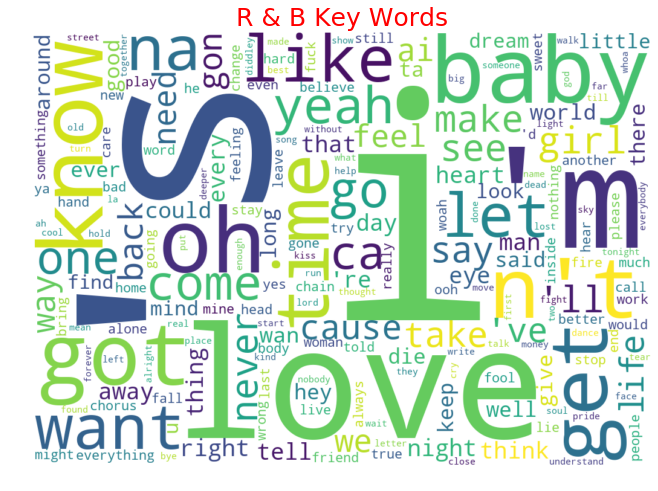

In [107]:
from wordcloud import WordCloud

# Initialize the word cloud

d = {}
for a, x in weights:
    d[a] = x
    
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

wc.generate_from_frequencies(d)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.title("R & B Key Words", color = "r", fontsize = 25)
plt.axis("off")
plt.show()